In [98]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import statsmodels.api as sm

Let us do a strategy of predicting the price of one of the stocks. Let us take the stock with ticker 1332JT.

In [99]:
df=pd.read_csv("/Users/danielbussell/Downloads/data.csv")
count=sum(df['ticker']=='1332 JT')
count

2005

In [100]:
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)

In [101]:
df_stock1=df.iloc[:2005]
df_stock1

,ticker,last,volume
date,,,
2013-01-04,1332 JT,169.0987,1464100
2013-01-07,1332 JT,166.3266,1783500
2013-01-08,1332 JT,166.3266,1759800
2013-01-09,1332 JT,165.4026,767800
2013-01-10,1332 JT,167.2507,1503100
...,...,...,...
2021-03-15,1332 JT,560.0000,1537500
2021-03-16,1332 JT,559.0000,1594200
2021-03-17,1332 JT,561.0000,1328200


(array([15340., 15706., 16071., 16436., 16801., 17167., 17532., 17897.,
        18262., 18628.]),
 [Text(15340.0, 0, '2012'),
  Text(15706.0, 0, '2013'),
  Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021')])

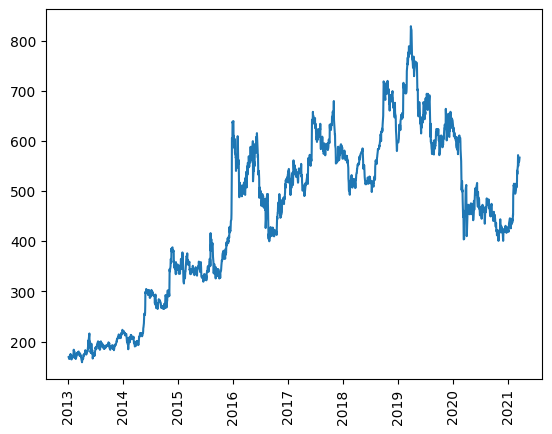

In [102]:
plt.plot(df_stock1['last'])
plt.xticks(rotation=90)

Do we have any missing values/noise?

In [103]:
missing_vals = sum(np.isnan(df_stock1['last']))
missing_vals

0

To see which type of model we should use we need to see if our data is stationary or not. Let us do an Augmented-Dicky-Fuller test and see...

In [104]:
adf_test= sm.tsa.stattools.adfuller(df_stock1['last'])
adf_test
print('p-value is',adf_test[1])

p-value is 0.34955395841856607


At the 99% level we can see that the data is non-stationary, therefore this would make prediction methods like linear regression and ARIMA unreliable. Let us use some neural networks like LSTM and GRU instead. Just need to find an appropraite number of lags...

/Users/danielbussell/opt/anaconda3/envs/amd_gpu/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


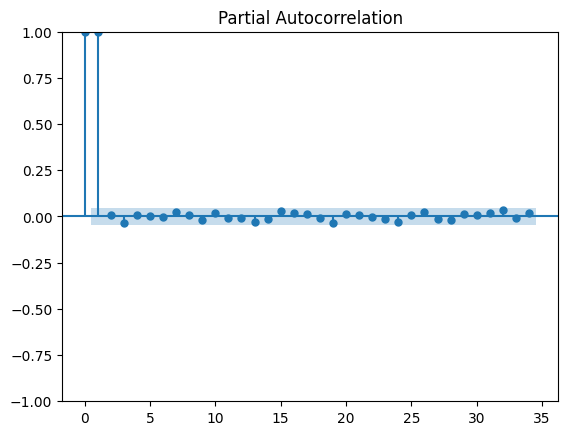

In [105]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pacf=plot_pacf(df_stock1['last'])


The PACF plot shows us that we should use a minimum of 2 steps for the lag. We have been given both volume and price data so let us use these as features to predict the price.

In [106]:
n_steps = 2
features = ['last']
target = ['last']

In order to train the model and do the backtest on some of our historical data, we need to split the data into training and test sets. Let us do this in a 80-20 split of train-test.

In [107]:
weight = 0.8
split =int(weight*len(df_stock1))
df_train= df_stock1[features].iloc[:split]
df_test= df_stock1[features].iloc[split:]

Neural networks learn best when the data is standardised so we shall do this...

In [108]:
mu=np.float(df_train.mean())
sigma=np.float(df_train.std())
standardise=lambda x: (x-mu)/sigma
df_train=df_train.apply(standardise)

/var/folders/ny/8tmjfmq51yq71k_19n708tfw0000gn/T/ipykernel_36862/3210593343.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mu=np.float(df_train.mean())
/var/folders/ny/8tmjfmq51yq71k_19n708tfw0000gn/T/ipykernel_36862/3210593343.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigma=np.float(df_train.std())


In [109]:
df_test=df_test.apply(standardise)

In [110]:
import keras
import keras.initializers
from keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
from keras.models import Sequential
from keras.models import load_model
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping

Recurrent neural networks like LSTM and GRU use time lagged windows as inputs so we write a function to get those lagged features

In [111]:
def get_lagged_features(df, n_steps, n_steps_ahead):
  
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [112]:
x_train = get_lagged_features(df_train, n_steps, 2)
y_train =  df_train.values[n_steps + 1:]
y_train_timestamps = df_train.index[n_steps + 1:]

x_test = get_lagged_features(df_test, n_steps, 2)
y_test =  df_test.values[n_steps + 1:]
y_test_timestamps = df_test.index[n_steps + 1:]

In [113]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(1601, 2, 1), (1601, 1), (398, 2, 1), (398, 1)]


In [114]:
def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [115]:
model_1=GRU_(10,0,0)
batch_size=1000
epochs=1000
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)
model_1.fit(x_train,y_train,epochs=epochs,batch_size=batch_size, callbacks=[es],shuffle=False)

Epoch 1/1000
2/2 [==============================] - 1s 5ms/step - loss: 2.4276
Epoch 2/1000
2/2 [==============================] - 0s 4ms/step - loss: 2.3788
Epoch 3/1000
2/2 [==============================] - 0s 5ms/step - loss: 2.3318
Epoch 4/1000
2/2 [==============================] - 0s 7ms/step - loss: 2.2852
Epoch 5/1000
2/2 [==============================] - 0s 8ms/step - loss: 2.2391
Epoch 6/1000
2/2 [==============================] - 0s 8ms/step - loss: 2.1937
Epoch 7/1000
2/2 [==============================] - 0s 5ms/step - loss: 2.1488
Epoch 8/1000
2/2 [==============================] - 0s 5ms/step - loss: 2.1045
Epoch 9/1000
2/2 [==============================] - 0s 4ms/step - loss: 2.0609
Epoch 10/1000
2/2 [==============================] - 0s 5ms/step - loss: 2.0179
Epoch 11/1000
2/2 [==============================] - 0s 5ms/step - loss: 1.9754
Epoch 12/1000
2/2 [==============================] - 0s 5ms/step - loss: 1.9336
Epoch 13/1000
2/2 [==============================

In [116]:
y_pred=model_1.predict(x_test)

13/13 [==============================] - 0s 972us/step


(array([18078., 18140., 18201., 18262., 18322., 18383., 18444., 18506.,
        18567., 18628., 18687.]),
 [Text(18078.0, 0, '2019-07'),
  Text(18140.0, 0, '2019-09'),
  Text(18201.0, 0, '2019-11'),
  Text(18262.0, 0, '2020-01'),
  Text(18322.0, 0, '2020-03'),
  Text(18383.0, 0, '2020-05'),
  Text(18444.0, 0, '2020-07'),
  Text(18506.0, 0, '2020-09'),
  Text(18567.0, 0, '2020-11'),
  Text(18628.0, 0, '2021-01'),
  Text(18687.0, 0, '2021-03')])

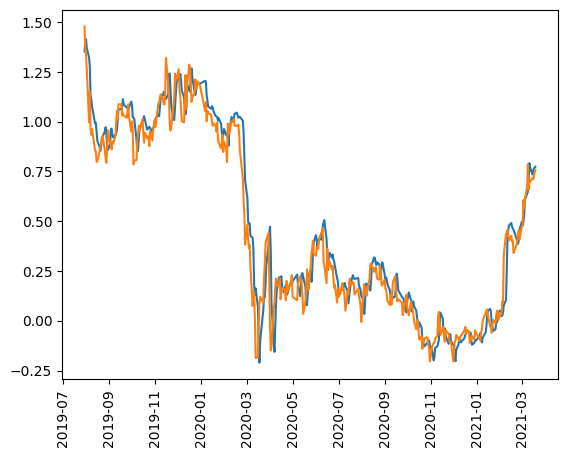

In [121]:
x_vals=y_test_timestamps
y_vals=y_pred
plt.plot(x_vals,y_vals)
plt.plot(x_vals,y_test)
plt.xticks(rotation=90)

In [118]:
model_2=LSTM_(10,0,0)
batch_size=1000
epochs=1000
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)
model_2.fit(x_train,y_train,epochs=epochs,batch_size=batch_size, callbacks=[es],shuffle=False)

Epoch 1/1000
2/2 [==============================] - 0s 5ms/step - loss: 1.7500
Epoch 2/1000
2/2 [==============================] - 0s 4ms/step - loss: 1.7336
Epoch 3/1000
2/2 [==============================] - 0s 4ms/step - loss: 1.7177
Epoch 4/1000
2/2 [==============================] - 0s 5ms/step - loss: 1.7018
Epoch 5/1000
2/2 [==============================] - 0s 5ms/step - loss: 1.6860
Epoch 6/1000
2/2 [==============================] - 0s 8ms/step - loss: 1.6701
Epoch 7/1000
2/2 [==============================] - 0s 9ms/step - loss: 1.6543
Epoch 8/1000
2/2 [==============================] - 0s 5ms/step - loss: 1.6386
Epoch 9/1000
2/2 [==============================] - 0s 7ms/step - loss: 1.6229
Epoch 10/1000
2/2 [==============================] - 0s 10ms/step - loss: 1.6073
Epoch 11/1000
2/2 [==============================] - 0s 9ms/step - loss: 1.5917
Epoch 12/1000
2/2 [==============================] - 0s 8ms/step - loss: 1.5761
Epoch 13/1000
2/2 [=============================

In [119]:
LSTM_pred=model_2.predict(x_test)


13/13 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'Network vs Real Prices')

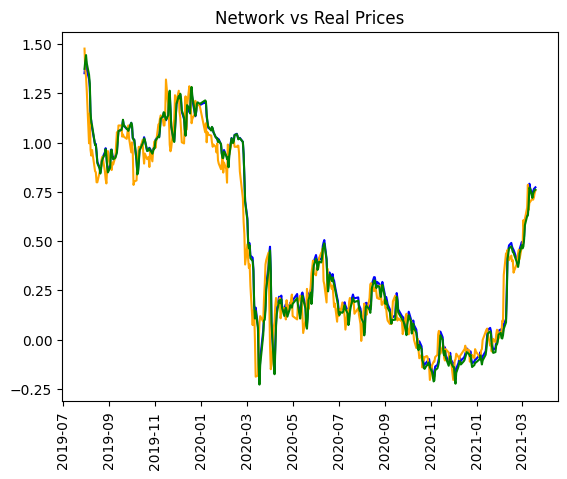

In [120]:
x_vals=y_test_timestamps
GRU_vals=y_pred
LSTM_vals=LSTM_pred
plt.plot(x_vals,GRU_vals,color='blue')
plt.plot(x_vals,y_test,color='orange')
plt.plot(x_vals,LSTM_pred,color='green')
plt.xticks(rotation=90)
plt.title('Network vs Real Prices')


We note that either of our neural network prediction strategies provide relatively good results